In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import os
import pickle
import importlib
import detect_bursts
importlib.reload(detect_bursts)
import copy
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,balanced_accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_predict,StratifiedGroupKFold,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
#XGBOOST
from xgboost import XGBClassifier
import xgboost
from pygam import GAM, s, f, LogisticGAM
from collections import defaultdict
from sklearn import tree
from scipy.io import loadmat
import json
import optuna
from sklearn.pipeline import Pipeline

Load Unlabeled Data

In [2]:
def convertIntoFloatList(str):
    #preprocess data extracted
    #remove the "[" and "]" characters
    str = str[1:-1]
    if str == '':
        return None
    return np.array(str.split(','),dtype = float)

def readData(frame,mothName):
    #convert dataframe rows into an entire list
    tp = []
    nameArr = []
    for ind in frame.index:
        inc = convertIntoFloatList(frame[ind])
        if inc is not None:
            tp.append(inc)
            nameArr.append(mothName)
    return tp,nameArr

#load xlsx data, extract column with largest pre_stim
def argMaxPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMaxColName = df.columns[np.argmax(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMaxColName}##########")
    return argMaxColName

#load xlsx data, extract column with smallest pre_stim
def argMinPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMinColName = df.columns[np.argmin(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMinColName}##########")
    return argMinColName

#load csv data, extract timestamps
def loadData(mothNum):
    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/{mothNum}_spontaneous.csv'

    df = pd.read_csv(loadPath, header = 0)
    
    
    #take samples with stimuli giving largest pre_stim value in first row
    # stimuli = argMinPreStim(mothNum)
    # Df = df.loc[df['stimuli'] == stimuli]
    

    tempDf = []
    tempName = []
    tempNeuron = []
    tempStimuli = []

    neuronCols = list(df.columns[3:])
    stimuli = df['stimuli'][0]
    
    for neuron in neuronCols:
        curArr,nameArr = readData(df[neuron],mothNum)
        tempDf += curArr
        tempName += nameArr
        tempNeuron += [neuron] * len(curArr)
        tempStimuli += [stimuli] * len(curArr)

    #add an entire column of mothNums at the end of tempDf
    #tempDf = np.array(tempDf)
    #mothNums = np.full((tempDf.shape[0],1),mothNum)
    #tempDf = np.concatenate((tempDf,mothNums),axis = 1)
    # print(tempName)

    return tempDf,tempName,tempNeuron,tempStimuli


#start collecting data for logistic regression
def collectModelData(mothNames):
    #for each moth, for each trial, for each neuron, render 9 parameters
    totalDf = []
    totalName = []
    totalNeuron = []
    totalStimuli = []
    for mothName in mothNames:
        mothDf,mothNameArr,mothNeuronArr,mothStimuliArr = loadData(mothName)
        print(f"########current number of rows: {len(mothDf)}########")
        totalDf += mothDf
        totalName += mothNameArr
        totalNeuron += mothNeuronArr
        totalStimuli += mothStimuliArr
    
    print("############all data loaded############")
    #print row number of totalDf
    print(f"############totalDf row number{len(totalDf)}############")

    return totalDf,totalName,totalNeuron,totalStimuli

#GIT data for unsupervised learning
mothNames = ['070906', '070913', '070921', '070922', '070924_1', '070924_2', '071002']
totalDf,totalName,totalNeuron,totalStimuli = collectModelData(mothNames)


########current number of rows: 12########
########current number of rows: 7########
########current number of rows: 14########
########current number of rows: 15########
########current number of rows: 16########
########current number of rows: 15########
########current number of rows: 14########
############all data loaded############
############totalDf row number93############


Labeled Data 

In [3]:
# # #pickle the dataframe (which essentially stores the timestamps data)
# # spikeDf.to_pickle("~/Documents/GitHub/AL_generative/labeled_data/spike_df.pkl")

# #pickle load spikeDf
# spikeDf = pd.read_pickle("~/Documents/GitHub/AL_generative/labeled_data/spike_df.pkl")


# #read labeled_data/verified_LNs.txt file
# verified_LNs = np.loadtxt("/Users/Ocelottamer/Documents/GitHub/AL_generative/labeled_data/verified_LNs.txt",dtype=str)

# #read labeled_data/verified_verified_PNs.xslx file, convert to 
# verified_PNs = pd.read_excel("/Users/Ocelottamer/Documents/GitHub/AL_generative/labeled_data/verified_PNs.xlsx",header=None)
# verified_PNs = list(verified_PNs.iloc[:,0])
# #for each element in verified_PNs, add 0 to front if it has only 8 digits
# for i in range(len(verified_PNs)):
#     if len(str(verified_PNs[i])) == 8:
#         verified_PNs[i] = "0" + str(verified_PNs[i])
#     else:
#         verified_PNs[i] = str(verified_PNs[i])


# #create spike_df, with only verified LNs and verified PNs in spikeDf
# verified_LNs_df = spikeDf[spikeDf['mothname'].isin(verified_LNs)]
# verified_PNs_df = spikeDf[spikeDf['mothname'].isin(verified_PNs)]
# spike_df = pd.concat([verified_LNs_df,verified_PNs_df],axis=0,ignore_index=True)
# #replace label column with 0 for LN and 1 for PN
# spike_df['label'] = spike_df['label'].replace({'LN':0,'PN':1})

# #divide timestamp by 1000 to get seconds
# spike_df['timestamps'] = spike_df['timestamps'].apply(lambda x: x/1000)

# #remind ourselves that this operates on the filtered data
# filtered_df = spike_df

# display(filtered_df)


Derive Nine Parameters

In [4]:
#from timestamp data count average spike frequency (spike count/duration)
def countSpikingFreq(timestamps):
    sum_duration = 0
    spike_count = 0
    for timestamp in timestamps:
        sum_duration += timestamp[-1] - timestamp[0]
        spike_count += len(timestamp)
    return spike_count/sum_duration

#within-burst number of spikes
def withinBurstNumSpikes(burstIndicator):
    num = len(np.where(burstIndicator == 1)[0])
    percentage = num/burstIndicator.shape[0]
    return num,percentage

#burst duration and inter-burst interval
def durations(timestamps,finalBurstRanges):
    burst = timestamps[finalBurstRanges[0][1]] - timestamps[finalBurstRanges[0][0]]
    #here we assume interBurst doesn't include the start-first-burst interval or the last-burst-end interval
    interBurstSt = finalBurstRanges[0][1]
    interBurst = 0

    maxSpikingFreq = (finalBurstRanges[0][1] - finalBurstRanges[0][0] + 1)/burst

    #tuple representing current burst
    for tup in finalBurstRanges[1:]:
        burstInc = timestamps[tup[1]] - timestamps[tup[0]]
        burst += burstInc
        interBurst += timestamps[tup[0]] - timestamps[interBurstSt]
        interBurstSt = tup[1]

        #count spikes within current burst
        curSpikingFreq = (tup[1]-tup[0]+1)/burstInc
        if maxSpikingFreq < curSpikingFreq:
            maxSpikingFreq = curSpikingFreq

    # burst /= 1000
    # interBurst /= 1000
    # maxSpikingFreq *= 1000
    return burst,interBurst,maxSpikingFreq

#within-burst spiking frequency
def meanSpikingFreq(num,duration):
    return num/duration
    # return num/duration * 1000

#surprise values
def surpriseEval(finalBurstSurprises):
    meanSurprise = np.mean(finalBurstSurprises)
    maxSurprise = np.max(finalBurstSurprises)
    return meanSurprise,maxSurprise

#mean burst frequency
def meanBurstFreq(finalNumBursts,totalTime):
    meanburstFreq = finalNumBursts/totalTime
    # meanburstFreq = meanburstFreq* 1000
    return meanburstFreq

#render 9 parameters for each sample (1 trial of 1 neuron)
def renderParams(timestamps,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime):
    withinBurstSpikeNum,withinBurstSpikePercentage = withinBurstNumSpikes(burstIndicator)
    duration,interBurst,maxSpikingFreq = durations(timestamps,finalBurstRanges)
    meanSpikingFreq = withinBurstSpikeNum/duration
    meanSurprise,maxSurprise = surpriseEval(finalBurstSurprises)
    meanburstFreq = meanBurstFreq(finalNumBursts,totalTime)
    return [duration,meanSpikingFreq,maxSpikingFreq,withinBurstSpikeNum,\
            interBurst,withinBurstSpikePercentage,meanburstFreq,meanSurprise,maxSurprise]


def formulateDataset(totalDf,totalName = None,totalLabel = None,p = 0.5):
    sampleDataset = []
    nameRes = []
    labelRes = []

    no_burst_sampleDataset = []
    no_burst_nameRes = []
    no_burst_labelRes = []

    if totalName is None:
        totalName = ['']*(totalDf.shape[0])

    if totalLabel is None:
        totalLabel = [0]*(totalDf.shape[0])
        
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2,p)
        
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(\
                lInput,finalBurstRanges,finalBurstSurprises,\
                    burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
            labelRes.append(totalLabel[index])

        else:
            #no burst in current list of timestamps
            no_burst_sampleDataset.append(dfRow)
            no_burst_nameRes.append(totalName[index])
            no_burst_labelRes.append(totalLabel[index])

    return sampleDataset,nameRes,labelRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_labelRes



def formulateDataset_unlabeled(totalDf,totalName = None,totalNeuron = None,totalStimuli = None,p = 0.5):
    sampleDataset = []
    nameRes = []
    neuronRes = []
    stimuliRes = []

    no_burst_sampleDataset = []
    no_burst_nameRes = []
    no_burst_neuronRes = []
    no_burst_stimuliRes = []


    if totalName is None:
        totalName = ['']*(len(totalDf))

    
    if totalNeuron is None:
        totalNeuron = ['']*(len(totalDf))
    
    if totalStimuli is None:
        totalStimuli = ['']*(len(totalDf))
        
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2,p)
        
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(\
                lInput,finalBurstRanges,finalBurstSurprises,\
                    burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
            neuronRes.append(totalNeuron[index])
            stimuliRes.append(totalStimuli[index])

        else:
            #no burst in current list of timestamps
            no_burst_sampleDataset.append(dfRow)
            no_burst_nameRes.append(totalName[index])
            no_burst_neuronRes.append(totalNeuron[index])
            no_burst_stimuliRes.append(totalStimuli[index])

    return sampleDataset,nameRes,neuronRes,stimuliRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes




#unsupervised -- save data into csv file
def saveData(Dataset,nameRes,neuronRes,stimuliRes):
    #load data from csv file
    savePath =  'unsupervised_learning/nine_parameters.csv'

    df = pd.DataFrame(Dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    df['Neuron'] = neuronRes
    df['Stimuli'] = stimuliRes
    
    # df.to_csv(savePath, index=False)
    return df


#supervised -- save data into csv file
def supervised_saveData(dataset,nameRes,labelRes,save_path = "~/Documents/GitHub/AL_generative/labeled_data/nine_burst_parameters.csv"):
    df = pd.DataFrame(dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    df['label'] = labelRes
    
    # #save parameters into csv file
    # df.to_csv(save_path, index=False)
    return df

#df = supervised_saveData(sampleDataset,nameRes,labelRes)


#count number of samples for each class in df
def countSamples(df):
    count = defaultdict(int)
    for index,row in df.iterrows():
        count[row['label']] += 1
    return count

#count = countSamples(df)
#print(count)


#define scoring function for later grid search based upon\
    #  AUC, F1 score, and accuracy as evaluation metrics
def evalCriterion(classifier,X,y):
    #prediction labels
    yPred = classifier.predict(X)

    #accuracy
    accu = accuracy_score(y,yPred)

    #F1
    f1 = f1_score(y,yPred)

    #AUC
    #we directly use the labels to compute the AUC scores \
    # (only considering threshold 0.5 while plotting the ROC curve)
    #with the same metric for all classifiers, \
    # we can compare the AUC scores to see which classifier is better
    yPred = classifier.predict_proba(X)[:,1]
    auc = roc_auc_score(y,yPred)
    
    return {'auc':auc,'F1':f1,'accu':accu}

def reductionClassification(sampleDF,lstColumnNames,reductionFunc,reductionParams,\
                            classifyingFunc,classifyingParamsDict,\
                                shuffleRandomState,isShuffle = True):
    #setup unsupervised classification training
    #shuffle sample dataset
    if isShuffle:
        sampleDF = shuffle(sampleDF,random_state=shuffleRandomState)

    #normalization
    sample = preprocessing.normalize(sampleDF[lstColumnNames])

    #X and y
    X = sample
    y = sampleDF['label']

    #split into training and test sets
    # X_train,X_test,\
    #     y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

    # fit clustering model with gridsearchCV
    dclf = GridSearchCV(classifyingFunc,classifyingParamsDict,\
                        cv=5,scoring=evalCriterion,\
                            refit='auc',verbose=5,n_jobs=1).fit(X,y).best_estimator_
    
    #predict on whole train set
    # pred_label = dclf.predict(X)

    # #predict on test set
    # pred_label_test = dclf.predict(X_test)

    pred_label = cross_val_predict(dclf,X,y,cv=5)
    
    #calculate AUC, F1 score and accuracy
    pred_AUC = roc_auc_score(y,pred_label)
    pred_F1 = f1_score(y,pred_label)
    pred_accu = accuracy_score(y,pred_label)

    #display
    print('AUC: ',pred_AUC)
    print('F1 score: ',pred_F1)
    print('Accuracy: ',pred_accu)
    
    
    #dimensionality reduction
    reducedSample = reductionFunc(**reductionParams).fit_transform(sample)

    #put 'Subject' and 'Label' back to reducedSample and form new dataframe
    reducedSampleDF = pd.DataFrame(reducedSample,columns=['PC1','PC2'])
    reducedSampleDF['Subject'] = copy.deepcopy(sampleDF['Subject'])
    reducedSampleDF['label'] = copy.deepcopy(sampleDF['label'])
    reducedSampleDF['pred_label'] = copy.deepcopy(pred_label)

    #give pred_label column also to sampleDF before dimensionality reduction
    sampleDF['pred_label'] = copy.deepcopy(pred_label)
    

    return sampleDF,reducedSampleDF,dclf



def histoResults(DF,lstColumnNames,plotFunc,plotParams,saveFileName = 'compare_histograms.pdf',barplot = False,\
                 figsize = (100,50),main_title = 'Comparison of histograms of 9 parameters',alpha = 0.3):
    #3x3 subplots
    fig,ax = plt.subplots(3,3,figsize=(15,15))
    # fig = plt.figure(figsize=figsize)
    #sns plot with hue of each of the nine parameters on a row for datapoints in each cluster
    num = len(lstColumnNames)
    for j in range(num):
        #use "y = " for barplot, "x =  " otherwise
        #figure into the jth subplot
        # fig.add_subplot(num,1,j+1)
        
        if barplot:
            #call barplot function, add a subplot to the 3x3 grid
            plotFunc(data=DF,y=lstColumnNames[j],ax=ax[j//3,j%3],**plotParams)

            
            for bar in ax[j//3,j%3].containers[0]:
                bar.set_alpha(alpha)

        else:
            #call plot function, add a subplot to the 3x3 grid
            plotFunc(data=DF,x=lstColumnNames[j],ax=ax[j//3,j%3],**plotParams)


        
            
    #main title
    fig.suptitle(main_title)

    #save pdf
    fig.savefig(saveFileName)
    plt.show()
    return


Three Rescaled Datasets

In [5]:
display(totalDf)

[array([17.1437, 17.1638, 17.1702, 17.2046, 17.2188, 17.2457, 17.2694,
        17.4844, 17.4965, 17.5062, 17.5543, 17.6392, 17.6652, 17.7928,
        17.8174, 18.8824, 18.9075, 19.2215, 19.2443, 19.2923, 19.696 ,
        19.7037, 19.805 ]),
 array([16.0076, 16.0728, 16.0798, 16.1174, 16.1687, 16.1875, 16.2199,
        16.2785, 16.4193, 16.4347, 16.5062, 16.5185, 16.5305, 16.5346,
        16.5529, 16.7391, 17.0222, 17.0859, 17.1523, 17.2681, 17.2783,
        17.3007, 17.304 , 17.3215, 17.3702, 17.4234, 17.4406, 17.5147,
        17.5316, 17.5449, 17.6216, 17.6361, 17.6947, 17.752 , 17.7748,
        17.7995, 17.8075, 17.9003, 18.701 , 18.7601, 18.8643, 18.9433,
        19.3699, 19.6723]),
 array([19.4153, 19.6343]),
 array([19.4293]),
 array([16.0835, 16.1781, 16.1951, 16.4575, 16.6217, 16.6641, 17.0181,
        17.0251, 17.1247, 17.1419, 17.1899, 17.2221, 17.2852, 17.5057,
        17.6412, 17.6589, 17.6781, 17.8487, 17.8693, 17.9497, 18.1114,
        18.2192, 18.458 , 18.5024, 18.5323, 1

In [6]:
# display(filtered_df)

In [7]:
ts = pd.read_pickle("LNandPN.pkl")
display(ts)

,mothname,timestamps,label
0,ts_LN_CR020108A,"[4.726, 4.8962, 5.0404, 5.2076, 5.3746, 5.5308...",0
1,ts_LN_CR020115A,"[0.16865, 0.37665, 0.58105, 0.70655, 0.7886, 0...",0
2,ts_LN_CR020208A,"[0.4579, 0.7831, 0.89105, 1.5872, 2.0686, 2.88...",0
3,ts_LN_CR020221A,"[0.36345, 0.3944, 0.7277, 0.75125, 10.049, 10....",0
4,ts_LN_CR020225B,"[2.7022, 2.9489, 3.1448, 3.4214, 3.6648, 3.916...",0
...,...,...,...
65,ts_PN_CR040914A,"[0.02805, 0.0454, 0.06255, 0.0809, 0.11385, 0....",1
66,ts_PN_CR040916A,"[0.527, 0.58105, 0.77755, 0.86615, 0.8882, 10....",1
67,ts_PN_CR040920A,"[2.9203, 2.9982, 3.0742, 3.1502, 3.2127, 3.271...",1
68,ts_PN_CR050104A,"[0.0685, 0.12855, 0.16985, 0.22035, 0.2668, 0....",1


Boxplot for Spiking Frequency

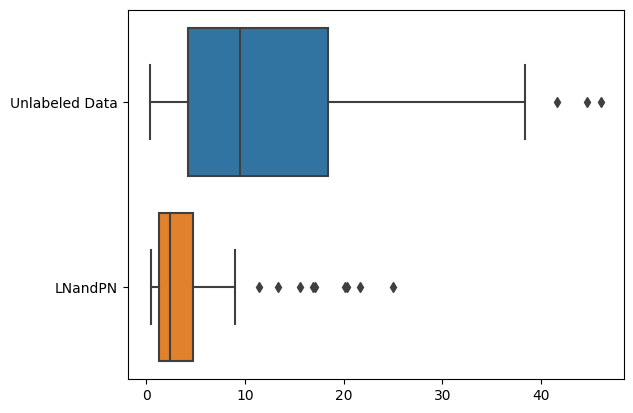

In [8]:
# for index in range(len(totalDf)):
#     print(index)
#     print(countSpikingFreq([totalDf[index]]))

#Unlabeled Data
#plot index,spiking frequency
spikingFreq_unlabeled = []
for index in range(len(totalDf)):
    spikingFreq_unlabeled.append(countSpikingFreq([totalDf[index]]))


# plt.plot(spikingFreq,color='blue')




#LNandPN
# for index,row in LNandPN.iterrows():
#     print(index)
#     print(countSpikingFreq([LNandPN['timestamps'][index]]))

#plot index,spiking frequency
spikingFreq_lnandpn = []
for index,row in ts.iterrows():
    spikingFreq_lnandpn.append(countSpikingFreq([ts['timestamps'][index]]))


# #second labeled data
# spikingFreq_lnpnfiltered = []
# for index,row in spike_df.iterrows():
#     spikingFreq_lnpnfiltered.append(countSpikingFreq([spike_df['timestamps'][index]]))

# spiking_freq = spikingFreq_unlabeled + spikingFreq_lnandpn + spikingFreq_lnpnfiltered
spiking_freq = spikingFreq_unlabeled + spikingFreq_lnandpn
# spiking_freq_labels = ['Unlabeled Data']*len(spikingFreq_unlabeled) + \
#     ['LNandPN']*len(spikingFreq_lnandpn) +\
#         ['LNandPN_filtered']*len(spikingFreq_lnpnfiltered)
spiking_freq_labels = ['Unlabeled Data']*len(spikingFreq_unlabeled) + \
    ['LNandPN']*len(spikingFreq_lnandpn)

sns.boxplot(x = spiking_freq,y=spiking_freq_labels)
# plt.plot(spikingFreq,color='red')
# plt.legend(['Unlabeled Data','LNandPN'])
# plt.xlabel('index')
# plt.ylabel('spiking frequency')
# plt.title('spiking frequency for each sample')

#save figure with size 15,15
plt.savefig('spiking_freq_Feb.jpg',bbox_inches='tight',dpi=300)


plt.show()

Parse through possible p values and compare scales

Unlabeled_0.2    172
PN_0.2            41
LN_0.2            11
Name: label, dtype: int64

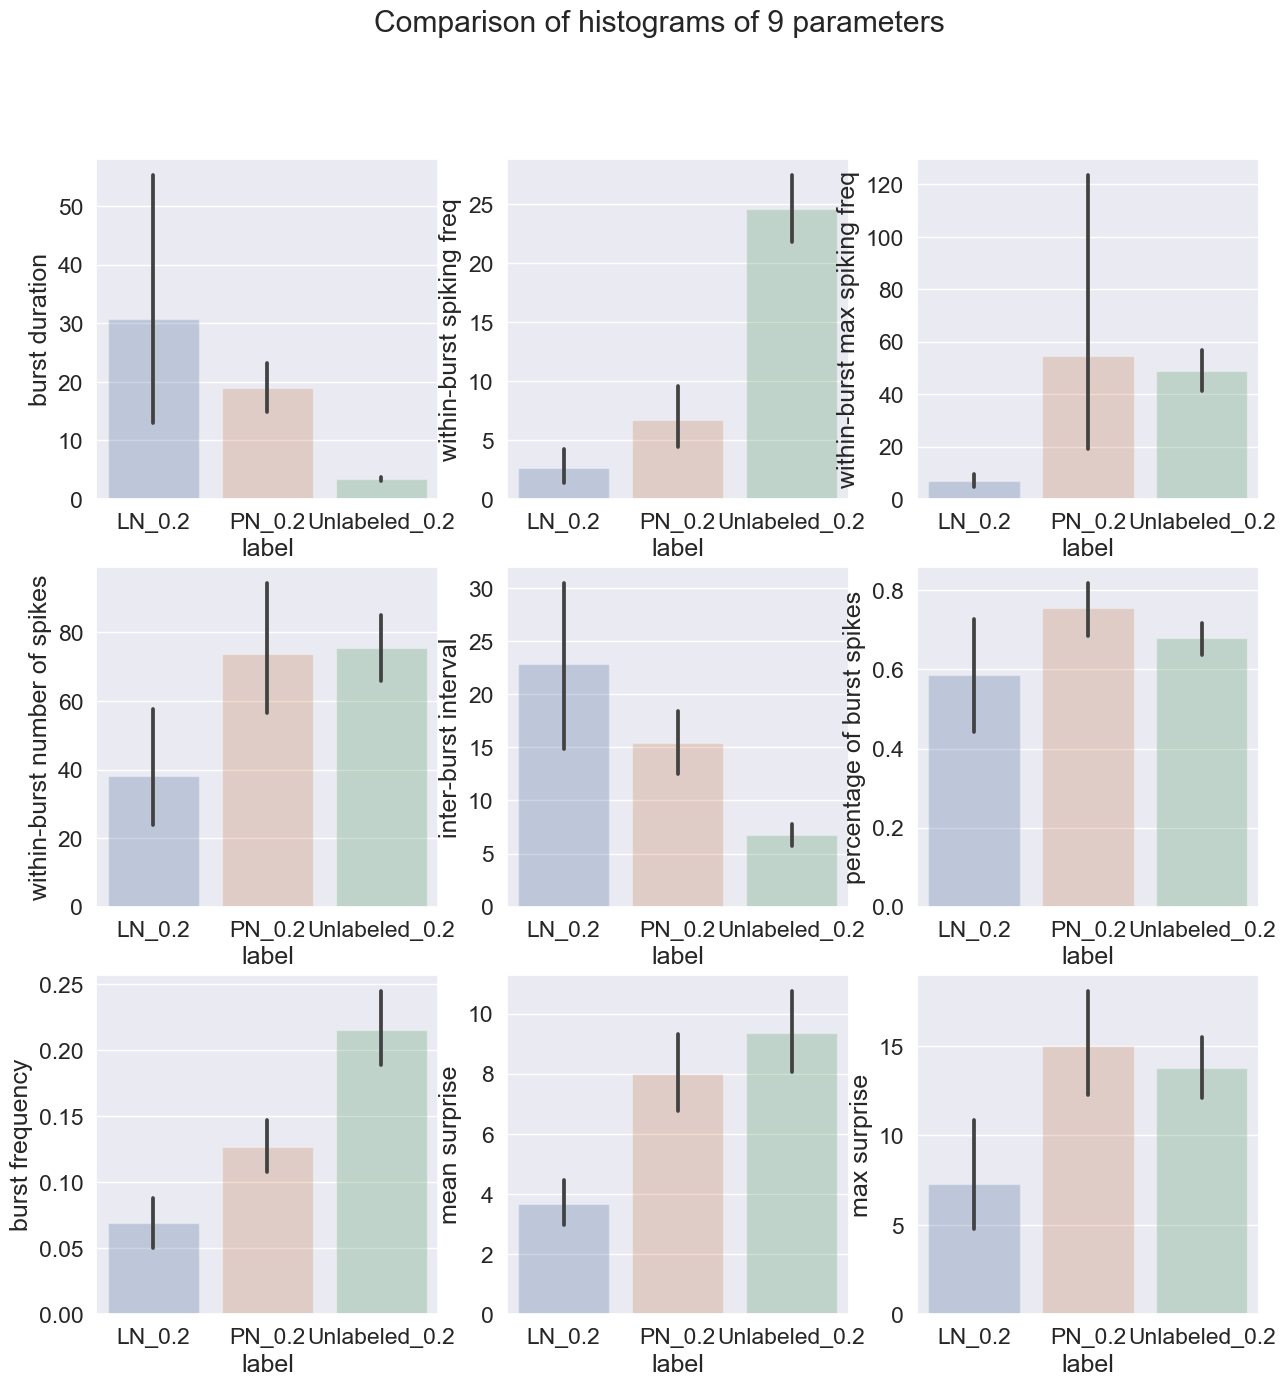

In [90]:
#neglect burst duration, within-burst spiking freq, and inter-burst interval in nine-cols
nine_cols = ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
             'within-burst number of spikes',\
                'inter-burst interval','percentage of burst spikes','burst frequency',\
                'mean surprise','max surprise']



#read LNandPN

res_df = pd.DataFrame(columns = nine_cols + ['label'])

#nine parameters
# for p in np.arange(0.02,0.2,0.02):
for p in [0.2]:
    ts_sampleDataset,ts_nameRes,ts_labelRes,\
        ts_no_burst_sampleDataset,ts_no_burst_nameRes,\
            ts_no_burst_labelRes = formulateDataset(ts['timestamps'],ts['mothname'],ts['label'],p = p)
    ts_df = supervised_saveData(ts_sampleDataset,ts_nameRes,ts_labelRes)

    LN_in_ts_df = ts_df[ts_df['label'] == 0]
    PN_in_ts_df = ts_df[ts_df['label'] == 1]
    LN_in_ts_df = LN_in_ts_df[nine_cols]
    LN_in_ts_df['label'] = f'LN_{p}'

    PN_in_ts_df = PN_in_ts_df[nine_cols]
    PN_in_ts_df['label'] = f'PN_{p}'

    res_df = pd.concat([res_df,LN_in_ts_df,PN_in_ts_df],axis=0,ignore_index=True)

# #filtered labeled data
# for p in [0.5]:
#     label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes,\
#         label_filtered_no_burst_sampleDataset,label_filtered_no_burst_nameRes,\
#             label_filtered_no_burst_labelRes = formulateDataset(spike_df['timestamps'],spike_df['mothname'],spike_df['label'],p = p)
#     label_filtered_df = supervised_saveData(label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes)
    
#     LN_in_label_filtered_df = label_filtered_df[label_filtered_df['label'] == 0]
#     PN_in_label_filtered_df = label_filtered_df[label_filtered_df['label'] == 1]
    
#     LN_in_label_filtered_df = LN_in_label_filtered_df[nine_cols]
#     LN_in_label_filtered_df['label'] = f'filtered_LN_{p}'
#     PN_in_label_filtered_df = PN_in_label_filtered_df[nine_cols]
#     PN_in_label_filtered_df['label'] = f'filtered_PN_{p}'
#     res_df = pd.concat([res_df,LN_in_label_filtered_df,PN_in_label_filtered_df],\
#                        axis=0,ignore_index=True)


#Unlabeled Data concatenated to res_df
# for p in np.arange(0.1,0.5,0.05):
for p in [0.2]:
    unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes,\
            unlabeled_no_burst_sampleDataset,unlabeled_no_burst_nameRes,\
                unlabeled_no_burst_neuronRes,unlabeled_no_burst_stimuliRes,\
                = formulateDataset_unlabeled(totalDf,totalName,totalNeuron,totalStimuli,p)
    unlabeled_df = saveData(unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes)
    unlabeled_df = unlabeled_df[nine_cols]
    unlabeled_df['label'] = f'Unlabeled_{p}'
    res_df = pd.concat([res_df,unlabeled_df],axis=0,ignore_index=True)

#concatenate unlabeled_df to res_df
res_df = pd.concat([res_df,unlabeled_df],axis=0,ignore_index=True)


display(res_df['label'].value_counts())

#barplot of res_df using histogram
histoResults(res_df,nine_cols,sns.barplot,{'x':'label'},\
             barplot = True,saveFileName = 'compare_histograms_LNandPN_Unlabeled_altered_Feb.pdf')

Choose appropriate p values and parameters for each of the three datasets

In [131]:
pruned_nine_cols = ['within-burst max spiking freq',\
                'within-burst number of spikes','percentage of burst spikes','burst frequency',\
                    'mean surprise','max surprise','label']

# pruned_nine_cols = ['within-burst number of spikes','burst frequency',\
#                     'mean surprise','max surprise','label']


#we temporarily make no major changes to filtered_df
# p = 0.5
# label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes,\
#     label_filtered_no_burst_sampleDataset,label_filtered_no_burst_nameRes,\
#         label_filtered_no_burst_labelRes = formulateDataset(filtered_df['timestamps'],filtered_df['mothname'],filtered_df['label'],p)
# label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes,\
#     label_filtered_no_burst_sampleDataset,label_filtered_no_burst_nameRes,\
#         label_filtered_no_burst_labelRes = formulateDataset(filtered_df['timestamps'],filtered_df['mothname'],filtered_df['label'],p)
# label_filtered_df = supervised_saveData(label_filtered_sampleDataset,label_filtered_nameRes,label_filtered_labelRes)[pruned_nine_cols]

# print("label_filtered_df")
# display(label_filtered_df)

#feature engineering parameter tuning
p = 0.2
#ts
ts_sampleDataset,ts_nameRes,ts_labelRes,\
    ts_no_burst_sampleDataset,ts_no_burst_nameRes,\
        ts_no_burst_labelRes = formulateDataset(ts['timestamps'],ts['mothname'],ts['label'],p)
ts_df = supervised_saveData(ts_sampleDataset,ts_nameRes,ts_labelRes)
ts_df_pruned = ts_df[pruned_nine_cols]

print("ts_df")
display(ts_df)


#unlabeled
p = 0.2
unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes,\
        unlabeled_no_burst_sampleDataset,unlabeled_no_burst_nameRes,\
            unlabeled_no_burst_neuronRes,unlabeled_no_burst_stimuliRes,\
            = formulateDataset_unlabeled(totalDf,totalName,totalNeuron,totalStimuli,p)
unlabeled_df = saveData(unlabeled_sampleDataset,unlabeled_nameRes,unlabeled_neuronRes,unlabeled_stimuliRes)
#no 'label' column here
unlabeled_df_pruned = unlabeled_df[pruned_nine_cols[:-1]]

print("unlabeled_df_pruned")
display(unlabeled_df_pruned)

print("unlabeled_df")
display(unlabeled_df)


sns.set(font_scale=1.5)

ts_df


,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,21.98430,1.637532,7.455268,36,37.52770,0.782609,0.077377,3.551334,6.606620,ts_LN_CR020108A,0
1,25.77850,1.163760,2.355158,30,14.80760,0.454545,0.027772,3.231017,4.948261,ts_LN_CR020208A,0
2,60.69475,0.939126,15.406162,57,38.75400,0.838235,0.099305,4.617048,12.350901,ts_LN_CR020221A,0
3,3.55200,4.786036,4.786036,17,0.00000,0.226667,0.014138,5.660686,5.660686,ts_LN_CR020225B,0
4,4.78210,5.855168,10.040161,28,28.72320,0.288660,0.046426,2.754773,4.552941,ts_LN_CR020311B,0
5,23.22030,1.335039,5.110733,31,27.35550,0.632653,0.074223,2.645764,4.200363,ts_LN_CR020322A,0
6,3.43300,8.738712,11.235955,30,9.50400,0.483871,0.120744,2.893227,5.188057,ts_LN_CR020327B,0
7,52.06215,2.170483,9.897550,113,38.53230,0.904000,0.099048,6.265610,23.480339,ts_LN_CR020910A,0
8,6.77850,1.180202,1.180202,8,0.00000,0.285714,0.040466,4.186473,4.186473,ts_LN_CR030618A,0
9,12.58655,1.032849,3.510620,13,27.34460,0.650000,0.073203,2.261379,2.934738,ts_LN_CR030710A,0


unlabeled_df_pruned


,within-burst max spiking freq,within-burst number of spikes,percentage of burst spikes,burst frequency,mean surprise,max surprise
0,21.568325,20,0.909091,0.100985,8.129553,13.005666
1,20.556698,37,0.860465,0.050833,22.067839,22.067839
2,10.524895,39,1.000000,0.050041,15.146894,15.146894
3,93.750000,13,1.000000,0.154292,6.023302,7.575765
4,2.875216,4,0.800000,0.050921,2.753871,2.753871
...,...,...,...,...,...,...
81,15.313936,39,0.750000,0.200954,4.030531,8.179410
82,70.422535,23,0.460000,0.255294,2.609333,3.521100
83,20.990764,50,0.769231,0.250262,3.750014,9.769924
84,233.918129,270,0.437601,0.950062,3.861261,18.424534


unlabeled_df


,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,Neuron,Stimuli
0,1.4453,13.837958,21.568325,20,1.1147,0.909091,0.100985,8.129553,13.005666,070906,S1U1,Lin
1,1.7999,20.556698,20.556698,37,0.0000,0.860465,0.050833,22.067839,22.067839,070906,S2U1,Lin
2,3.7055,10.524895,10.524895,39,0.0000,1.000000,0.050041,15.146894,15.146894,070906,S2U4,Lin
3,3.0363,4.281527,93.750000,13,0.0428,1.000000,0.154292,6.023302,7.575765,070906,S2U5,Lin
4,1.3912,2.875216,2.875216,4,0.0000,0.800000,0.050921,2.753871,2.753871,070906,S3U1,Lin
...,...,...,...,...,...,...,...,...,...,...,...,...
81,13.4148,2.907237,15.313936,39,3.0775,0.750000,0.200954,4.030531,8.179410,071002,S1U1_selectiveunit,Myr
82,2.6058,8.826464,70.422535,23,15.0734,0.460000,0.255294,2.609333,3.521100,071002,S1U2,Myr
83,4.4924,11.129908,20.990764,50,12.9673,0.769231,0.250262,3.750014,9.769924,071002,S1U3,Myr
84,2.6336,102.521264,233.918129,270,15.3836,0.437601,0.950062,3.861261,18.424534,071002,S1U4,Myr


Logistic Regression

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END estimator__C=0.01, estimator__penalty=None, estimator__solver=newton-cg, estimator__tol=0.

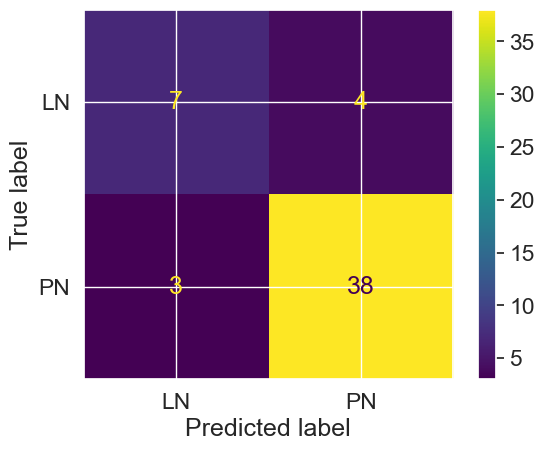

f1 score: 0.9156626506024096
balanced accuracy score: 0.7815964523281597


In [132]:
def tunaClassifier(XTrain,yTrain,NFold,scalerFunc,estimatorFunc,params):
    #create a pipeline composed of a minmaxscaler and then estimatorFunc
    pipe = Pipeline([('scaler',scalerFunc),('estimator',estimatorFunc)])
    #grid search cv
    grid_search_cv = GridSearchCV(pipe,params,cv=StratifiedKFold(n_splits=NFold,shuffle = True, random_state=42),\
                                  scoring='f1',refit='f1',verbose=5,n_jobs=1).fit(XTrain,yTrain)
    
    #best estimator inside pipeline
    lr_params = grid_search_cv.best_params_
    lr_params = {key[11:]:value for key,value in lr_params.items()}
    


    lr = grid_search_cv.best_estimator_
    lr_pred = cross_val_predict(lr,XTrain,yTrain,cv= StratifiedKFold(n_splits=NFold,shuffle=True,random_state=42))

    #display best params
    print(f"best params: {grid_search_cv.best_params_}")

    return lr_params,lr_pred



#use logistic regression to train on ts_df
ts_X = ts_df_pruned[pruned_nine_cols[:-1]]
ts_y = ts_df_pruned['label']
# ts_X = ts_df[nine_cols]

params = {'estimator__tol':[0.0001,0.001,0.01,0.1,1],\
            'estimator__C':[0.01,0.1,1,10,100],\
                'estimator__solver':['newton-cg','lbfgs','liblinear','sag','saga'],\
                    'estimator__penalty':['None','l1','l2','elasticnet']}



lr_params,lr_pred = tunaClassifier(ts_X,ts_y,5,preprocessing.MinMaxScaler(),LogisticRegression(),params)

#confusion matrix display
cm = confusion_matrix(ts_y,lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['LN','PN'])
disp.plot()
plt.x_label = 'Predicted label'
plt.y_label = 'True label'
#save confusion matrix
plt.savefig('lr_confusion_matrix.jpg',bbox_inches='tight',dpi=300)
plt.show()


#f1 score
f1 = f1_score(ts_y,lr_pred)
print(f"f1 score: {f1}")

#balanced accuracy score
balanced_accu = balanced_accuracy_score(ts_y,lr_pred)
print(f"balanced accuracy score: {balanced_accu}")

unlabeled_pred_proba: [0.39283467 0.94372084 0.72234437 0.41336715 0.11086224 0.12287752
 0.2226153  0.63147064 0.26743908 0.08962597 0.83860298 0.67706748
 0.09495261 0.13716514 0.12374966 0.89484522 0.41930765 0.21869849
 0.94090056 0.63513533 0.27194259 0.26455879 0.08221456 0.78888005
 0.32149672 0.42233501 0.48462253 0.9997704  0.15230252 0.86761067
 0.99960108 0.87429719 0.83263534 0.80199101 0.90100893 0.97618099
 0.99823388 0.87961418 0.14575281 0.97350847 0.94564164 0.62341736
 0.71909537 0.97874313 0.64457046 0.30830994 0.54599706 0.56131784
 0.6493731  0.37044659 0.59896803 0.32489792 0.92219855 0.48122294
 0.80447182 0.25609247 0.71285557 0.5697807  0.32612077 0.40761856
 0.4405431  0.97006709 0.29759898 0.54685942 0.35931423 0.22842809
 0.20351399 0.7630423  0.62551092 0.55457759 0.48734976 0.28202394
 0.36564303 0.91453938 0.83779735 0.83873627 0.96436814 0.53033184
 0.4216929  0.5751427  0.20090172 0.33117752 0.41014036 0.39012476
 0.98702834 0.57813345]


array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1])

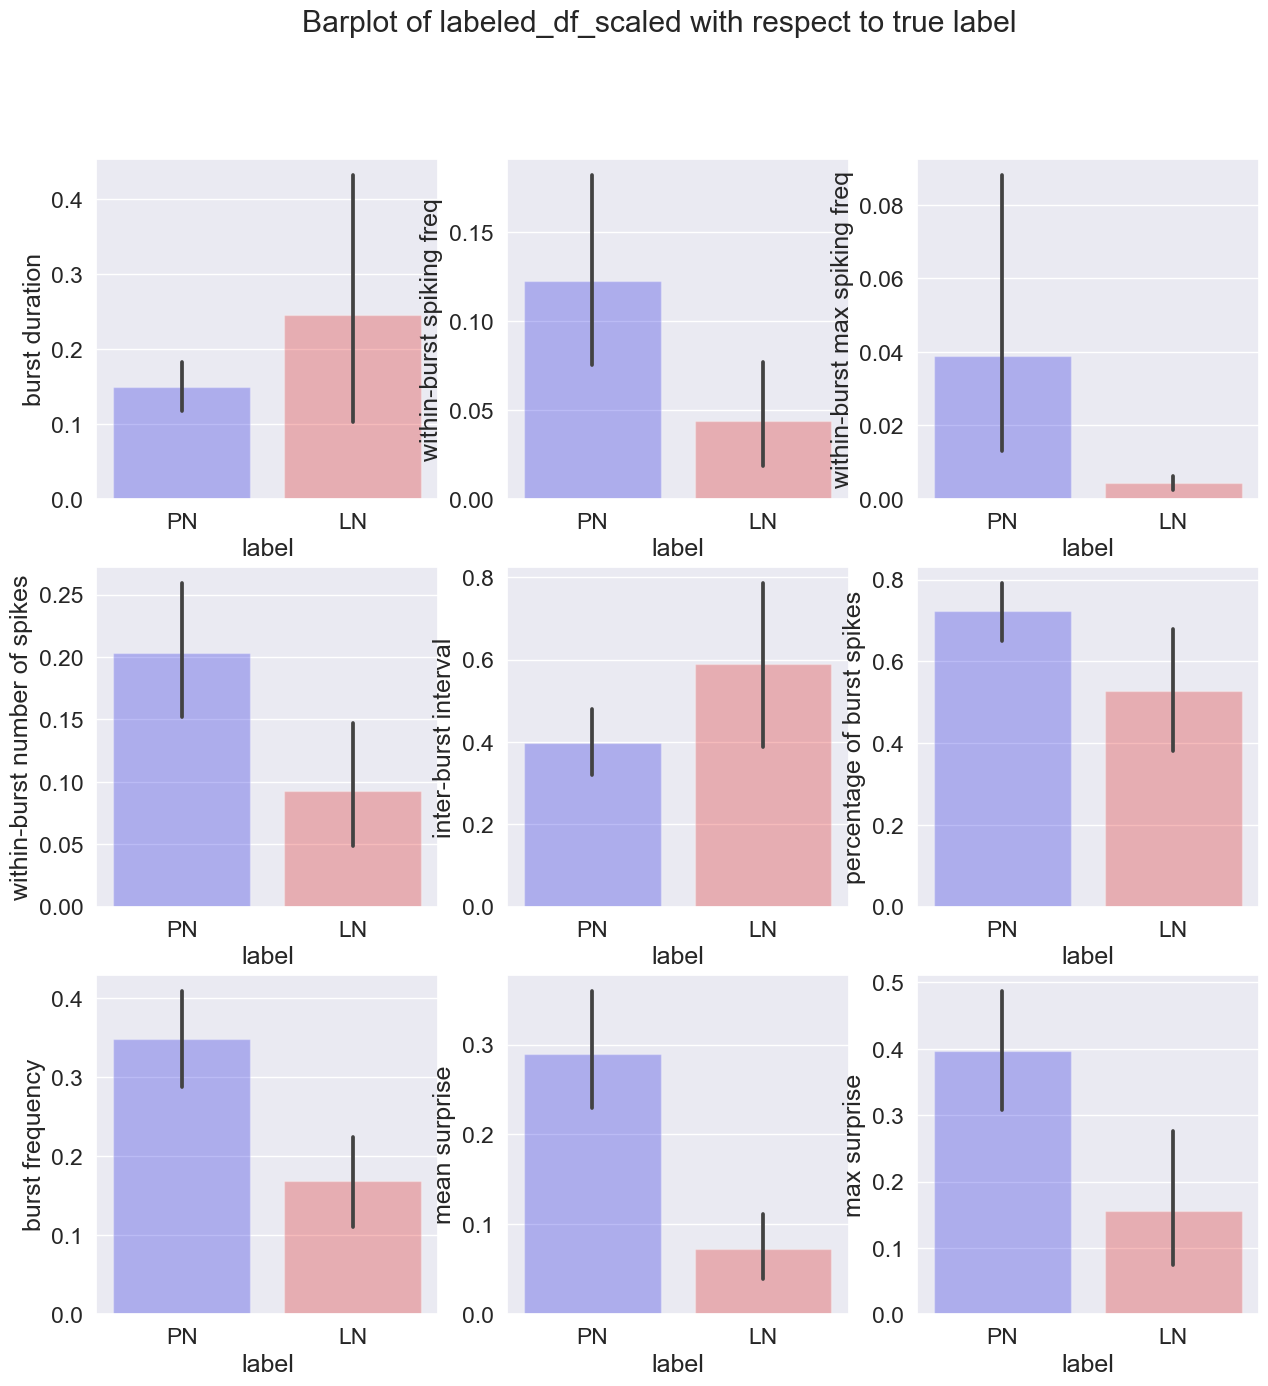

In [133]:
#Now, train lr on entire training set and test lr on unlabeled_df
ts_X_scaled = preprocessing.MinMaxScaler().fit_transform(ts_X)
lr = LogisticRegression(**lr_params)
lr.fit(ts_X_scaled,ts_y)

#prediction
unlabeled_df_pruned_scaled = preprocessing.MinMaxScaler().fit_transform(unlabeled_df_pruned)
unlabeled_pred = lr.predict(unlabeled_df_pruned_scaled)
unlabeled_pred_proba = lr.predict_proba(unlabeled_df_pruned_scaled)[:,-1]

# unlabeled_df_scaled = preprocessing.MinMaxScaler().fit_transform(unlabeled_df[nine_cols])
# unlabeled_pred = lr.predict(unlabeled_df_scaled)
# unlabeled_pred_proba = lr.predict_proba(unlabeled_df_scaled)[:,-1]

print(f"unlabeled_pred_proba: {unlabeled_pred_proba}")
unlabeled_df_with_pred = copy.deepcopy(unlabeled_df)
unlabeled_df_with_pred['label'] = unlabeled_pred
#replace 0 with LN and 1 with PN
unlabeled_df_with_pred['label'] = unlabeled_df_with_pred['label'].replace({0:'LN',1:'PN'})
display(unlabeled_pred)

#barplot of ts_df
#replace PN with 1 and LN with 0
#minmax scale the 9 parameters of ts_df
ts_df_scaled = preprocessing.MinMaxScaler().fit_transform(ts_df[nine_cols])
ts_df_scaled = pd.DataFrame(ts_df_scaled,columns=nine_cols)
ts_df['label'] = ts_df['label'].replace({0:'LN',1:'PN'})
ts_df_scaled['label'] = ts_df['label']
histoResults(ts_df_scaled,nine_cols,sns.barplot,{'x':'label','palette':['blue','red'],'order':['PN','LN']},\
             barplot = True,saveFileName = 'labeled_df_scaled_with_true_label.pdf',\
                figsize=(50,50),main_title='Barplot of labeled_df_scaled with respect to true label')

Tree-Based Method

Save Data as Json

In [134]:
display(unlabeled_df_with_pred)
#save unlabeled_df_with_pred to csv
unlabeled_df_with_pred.to_csv('unlabeled_df_with_pred_nine_params.csv',index=False)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,Neuron,Stimuli,label
0,1.4453,13.837958,21.568325,20,1.1147,0.909091,0.100985,8.129553,13.005666,070906,S1U1,Lin,LN
1,1.7999,20.556698,20.556698,37,0.0000,0.860465,0.050833,22.067839,22.067839,070906,S2U1,Lin,PN
2,3.7055,10.524895,10.524895,39,0.0000,1.000000,0.050041,15.146894,15.146894,070906,S2U4,Lin,PN
3,3.0363,4.281527,93.750000,13,0.0428,1.000000,0.154292,6.023302,7.575765,070906,S2U5,Lin,LN
4,1.3912,2.875216,2.875216,4,0.0000,0.800000,0.050921,2.753871,2.753871,070906,S3U1,Lin,LN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,13.4148,2.907237,15.313936,39,3.0775,0.750000,0.200954,4.030531,8.179410,071002,S1U1_selectiveunit,Myr,LN
82,2.6058,8.826464,70.422535,23,15.0734,0.460000,0.255294,2.609333,3.521100,071002,S1U2,Myr,LN
83,4.4924,11.129908,20.990764,50,12.9673,0.769231,0.250262,3.750014,9.769924,071002,S1U3,Myr,LN
84,2.6336,102.521264,233.918129,270,15.3836,0.437601,0.950062,3.861261,18.424534,071002,S1U4,Myr,PN


86

accuracy: 0.6451612903225806


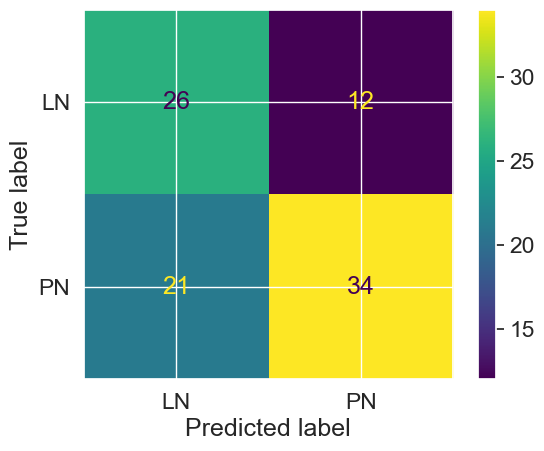

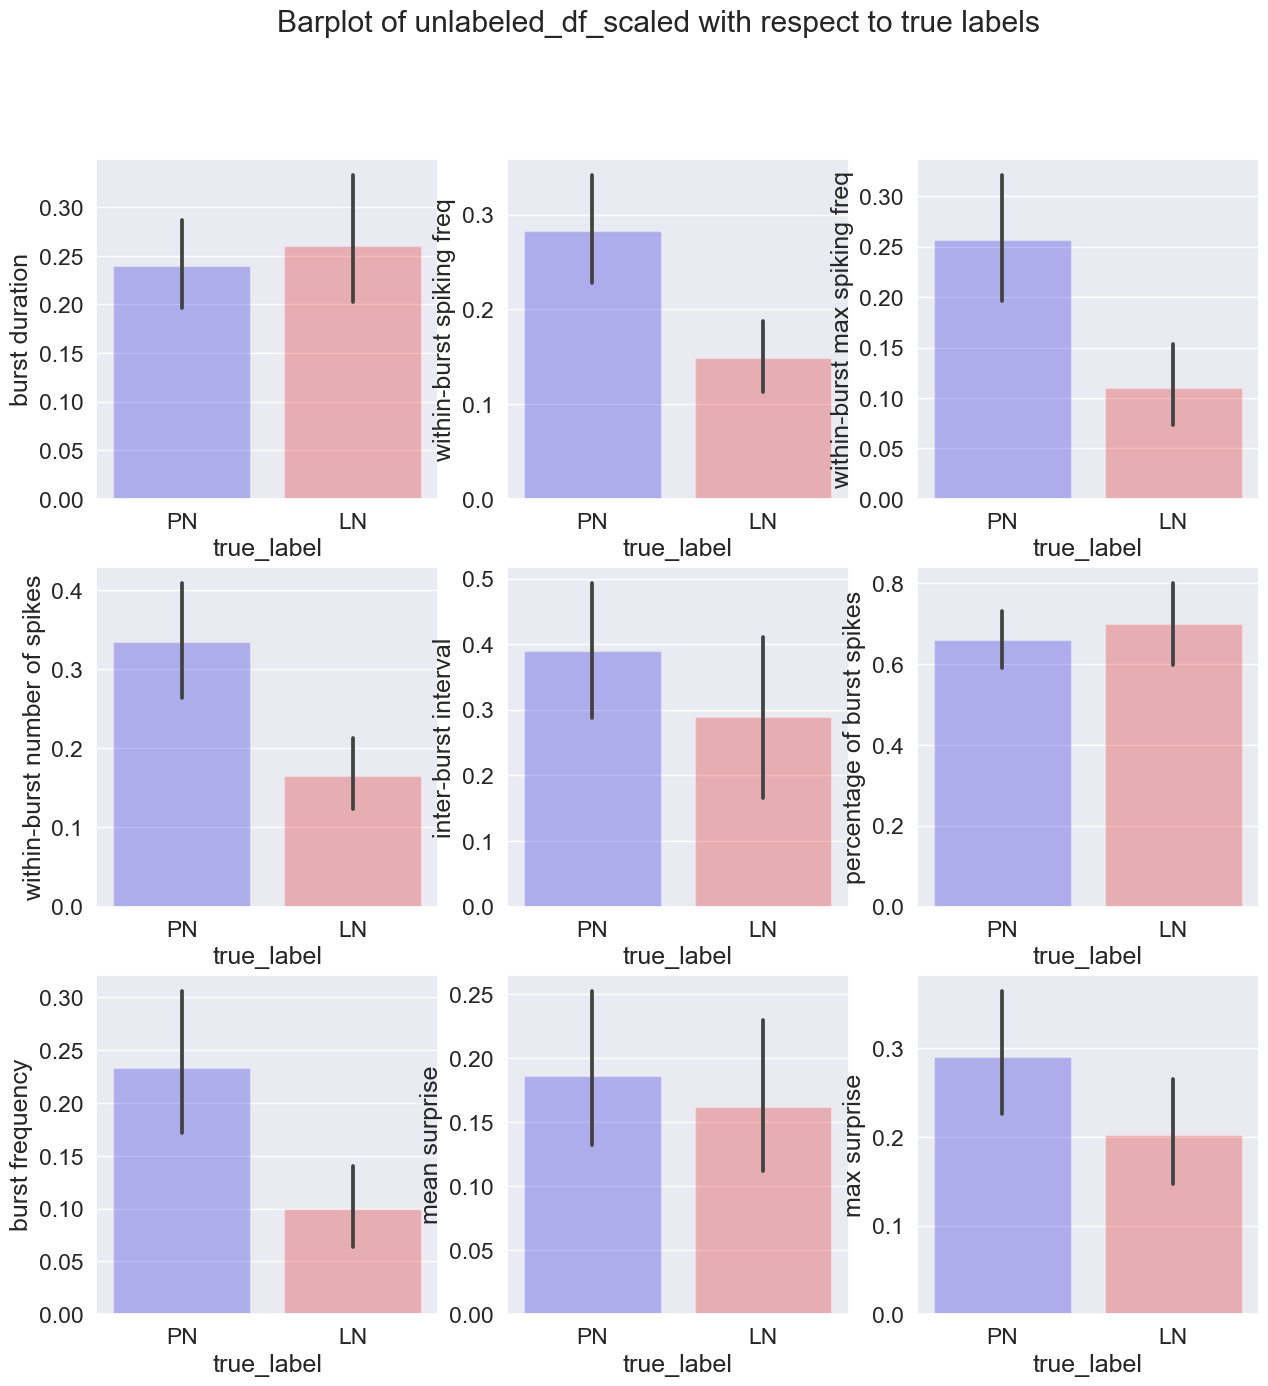

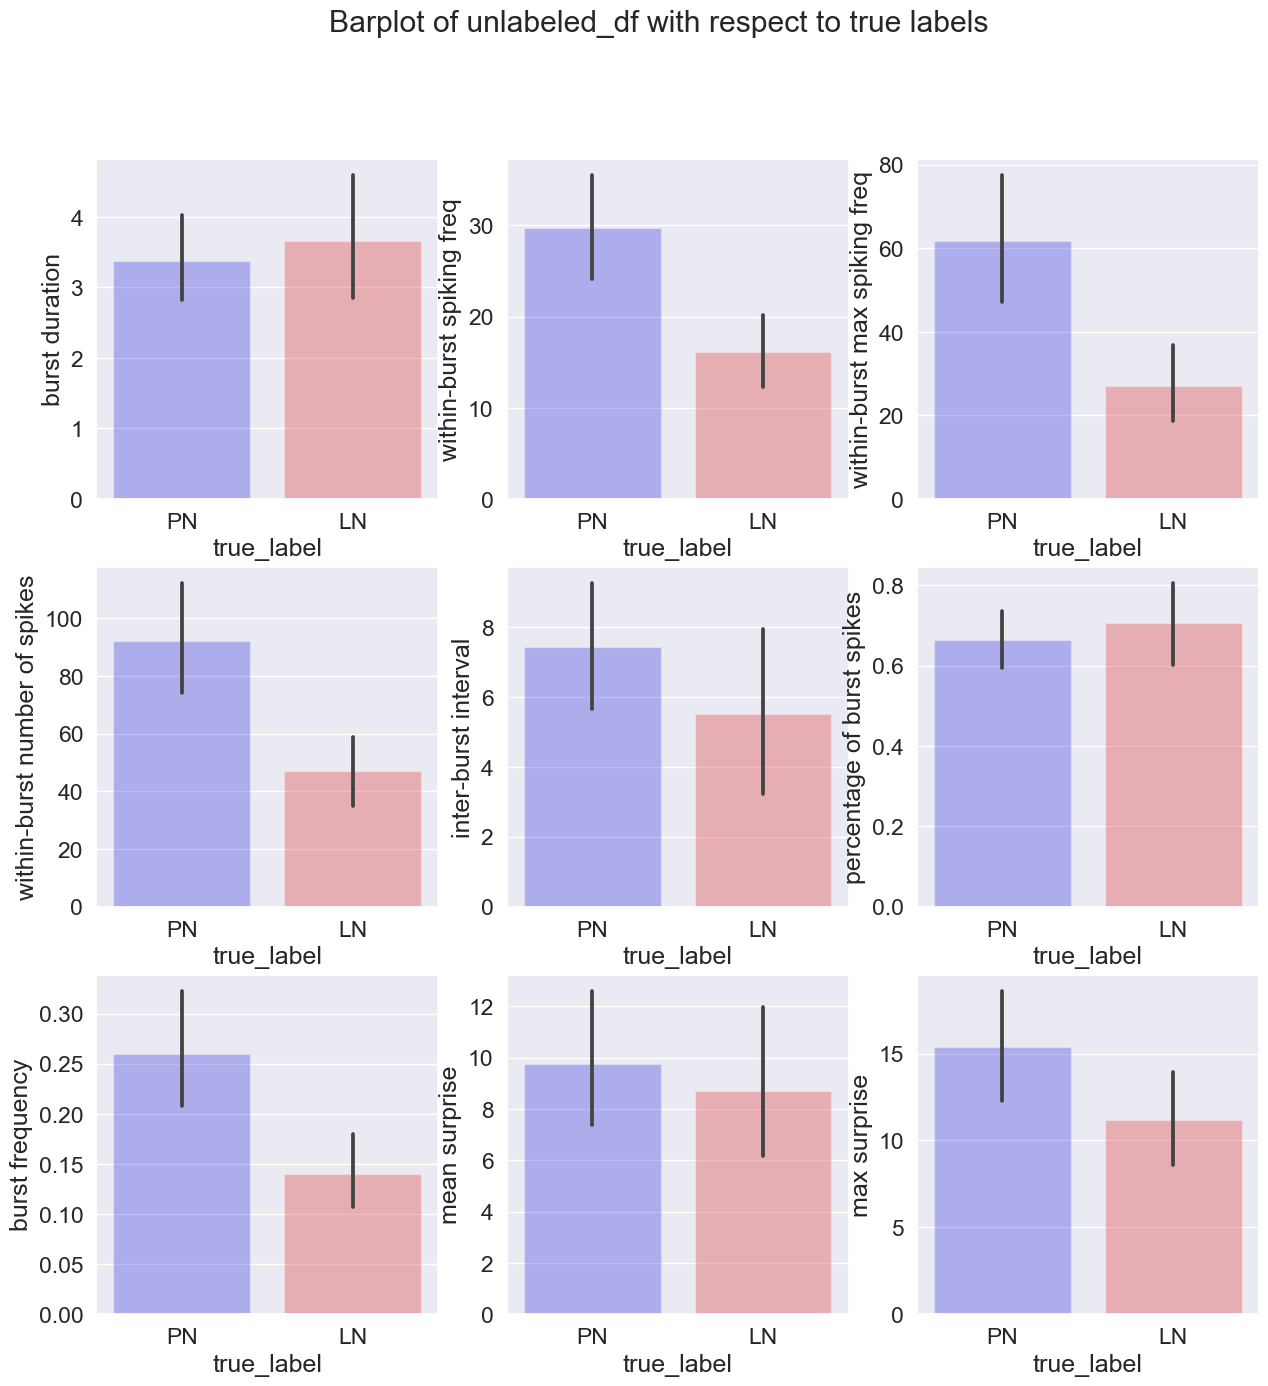

In [136]:
def get_label_from_true_json(data,name_base,neuron_base,true_json_data):
    true_label = []

    for i,label in enumerate(data):
        true_label.append(true_json_data[name_base[i]][neuron_base[i]]['true'])


    return true_label

true_json_data = json.load(open('unlabeled_pred.json'))
true_labels = get_label_from_true_json(unlabeled_pred,unlabeled_nameRes,unlabeled_neuronRes,true_json_data)
display(len(true_labels))
#add true_labels as a new column to unlabeled_df_with_pred
unlabeled_df_with_pred['true_label'] = true_labels

true_labels_no_burst = get_label_from_true_json(unlabeled_no_burst_nameRes,unlabeled_no_burst_nameRes,unlabeled_no_burst_neuronRes,true_json_data)
true_labels_extended = true_labels + true_labels_no_burst
#append LNs after predicted labels
unlabeled_pred_extended = list(unlabeled_df_with_pred['label']) + ['LN']*len(unlabeled_no_burst_nameRes)

#compute and display accuracy
accu = accuracy_score(true_labels_extended,unlabeled_pred_extended)
print(f"accuracy: {accu}")

#confusion matrix display
cm = confusion_matrix(true_labels_extended,unlabeled_pred_extended)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['LN','PN'])
disp.plot()
plt.x_label = 'Predicted label'
plt.y_label = 'True label'
#save confusion matrix
plt.savefig('unlabeled_lr_confusion_matrix_March.jpeg',bbox_inches='tight',dpi=300)


#read label and true_label columns of unlabeled_df_with_pred
unlabeled_scaler = preprocessing.MinMaxScaler()
unlabeled_df_scaled = unlabeled_scaler.fit_transform(unlabeled_df[nine_cols])
unlabeled_df_scaled = pd.DataFrame(unlabeled_df_scaled,columns=nine_cols)
unlabeled_df_scaled['true_label'] = true_labels
histoResults(unlabeled_df_scaled,nine_cols,sns.barplot,{'x':'true_label','palette':['blue','red'],'order':['PN','LN']},\
             barplot = True,saveFileName = 'unlabeled_df_scaled_true.pdf',\
                figsize=(50,50),main_title='Barplot of unlabeled_df_scaled with respect to true labels')

#barplot 
histoResults(unlabeled_df_with_pred,nine_cols,sns.barplot,{'x':'true_label','palette':['blue','red'],'order':['PN','LN']},\
             barplot = True,saveFileName = 'unlabeled_df_with_lr_pred_true.pdf',\
                figsize=(50,50),main_title='Barplot of unlabeled_df with respect to true labels')

In [15]:
def save_label_as_json(pred_data):

    #initialize json data
    json_data = {}

    for i,label in enumerate(pred_data):
        if label == 0:
            l = 'LN'
        else:
            l = 'PN'

        #set json data
        if unlabeled_nameRes[i] not in json_data:
            json_data[unlabeled_nameRes[i]] = {}

        # json_data[unlabeled_nameRes[i]][unlabeled_neuronRes[i]] = {'label':l,'stimuli':unlabeled_stimuliRes[i],\
        #     'within-burst max spiking freq':unlabeled_df['within-burst max spiking freq'][i],\
        #     'within-burst number of spikes':unlabeled_df['within-burst number of spikes'][i],\
        #     'percentage of burst spikes':unlabeled_df['percentage of burst spikes'][i],\
        #     'burst frequency':unlabeled_df['burst frequency'][i],\
        #     'mean surprise':unlabeled_df['mean surprise'][i],\
        #     'max surprise':unlabeled_df['max surprise'][i]}
        

        json_data[unlabeled_nameRes[i]][unlabeled_neuronRes[i]] = {'label':l,'stimuli':unlabeled_stimuliRes[i]}


    for i in range(len(unlabeled_no_burst_nameRes)):
        #set json data
        if unlabeled_no_burst_nameRes[i] not in json_data:
            json_data[unlabeled_no_burst_nameRes[i]] = {}

        json_data[unlabeled_no_burst_nameRes[i]][unlabeled_no_burst_neuronRes[i]] = {'label':'unknown','stimuli':unlabeled_no_burst_stimuliRes[i]}


    #save json data
    with open('unlabeled_pred_Feb.json','w') as f:
        json.dump(json_data,f)

    display(json_data)

    return json_data

# json_data = save_label_as_json(unlabeled_pred)

Spike Plotting (Bea, Ctl, totalDf)

In [16]:
def load_range_data(mothName,neuronName):
    #initialize dataframe
    two_seconds_df = pd.DataFrame(columns=['timestamp_start','timestamp_end','stimuli'])

    #confirm time range from timestamps csv 
    timestamps_csv_filename = f'~/Documents/GitHub/AL_generative/ALdata/timestamps_{mothName}.csv'
    timestamp_csv = pd.read_csv(timestamps_csv_filename,header=0)
    for stimulus in timestamp_csv.columns:
        if stimulus[0] != 'P' and stimulus[0] != 'M':


            timestamp_onset = timestamp_csv.iloc[0][stimulus]
            timestamp_end = timestamp_onset + 2
            #2 seconds before stimulus
            timestamp_start = timestamp_end - 2.5


            #load data from _prep.mat file
            prep_filename = f'../ALdata/{mothName}_prep.mat'
            prep = loadmat(prep_filename)
            prep_timestamps = list(i[0] for i in prep[neuronName])
            #crop the part of prep_timestamps where the time is larger than timestamp_start and smaller than timestamp_end
            cropped_prep_timestamps = [i for i in prep_timestamps if i >= timestamp_start and i <= timestamp_end]

            two_seconds_df = two_seconds_df.append({'timestamp_start':timestamp_start,\
                                                    'timestamp_end':timestamp_end,\
                                                    'timestamp_onset':timestamp_onset,\
                                                    'timestamps': cropped_prep_timestamps,\
                                                        'stimuli':stimulus},ignore_index=True)


    return two_seconds_df


def y_spikes(x_start,x_end,timestamps):
    x_bot = np.linspace(x_start,x_end,200000)

    y = []
    for x in x_bot:
        x = round(x,4)
        if x in timestamps:
            y.append(1)
        else:
            y.append(0)

    return x_bot,y

def plot_spike(index):

    loaded_range_data = load_range_data(totalName[index],totalNeuron[index])
    loaded_range_data_shape = loaded_range_data.shape[0]
    fig,axs = plt.subplots(1 + loaded_range_data_shape,1,figsize = (10, 6*loaded_range_data_shape))

    mothName = totalName[index]
    neuronName = totalNeuron[index]
    pred_label = json_data[mothName][neuronName]['label']

    #totalDf
    x_bot,y = y_spikes(0,20,totalDf[index])
    axs[0].plot(x_bot,y)
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('spike')
    axs[0].set_title(f"spike train of unlabeled test data {mothName}_{neuronName}_{pred_label}_Spontaneous")

    for row_index in range(loaded_range_data_shape):
        x_bot,y = y_spikes(loaded_range_data['timestamp_start'][row_index],\
                           loaded_range_data['timestamp_end'][row_index],\
                               loaded_range_data['timestamps'][row_index])
        axs[row_index + 1].plot(x_bot,y)
        y_min = min(y)
        #plot a  vertical line at x coordinate timestamp_onset
        axs[row_index + 1].vlines(x=loaded_range_data['timestamp_onset'][row_index],ymin = 0, ymax = 0.3, color='red')
        axs[row_index + 1].set_xlabel('time')
        axs[row_index + 1].set_ylabel('spike')
        axs[row_index + 1].set_title(f"spike train of {loaded_range_data['stimuli'][row_index]} {mothName}_{neuronName}_{pred_label}_{loaded_range_data['stimuli'][row_index]}")

    # plt.show()
    fig.savefig(f"stimuli_unlabeled_data_spikes_plots_1_19/stimuli_unlabeled_data_spikes_1_19_{mothName}_{neuronName}_{pred_label}.pdf")

    return

# for i in list(range(len(totalDf))):
#     print(i)
#     plot_spike(i)